### Transfer Learning using VGG16

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
target_img_shape = (64, 64)

train_dir = './train_set_321/'
val_dir = './validation_set/'
test_set = './test_set/'

# Process input to Model VGG16  + Data Augmentation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=20, height_shift_range=0.15, width_shift_range=0.15, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

# Read image file from folder
train_set = train_datagen.flow_from_directory(train_dir, target_size=target_img_shape, batch_size=32, class_mode='binary')

Found 321 images belonging to 2 classes.


In [24]:
validaion_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_set = validaion_datagen.flow_from_directory(val_dir, target_size=target_img_shape, batch_size=32, class_mode='binary')

Found 200 images belonging to 2 classes.


In [4]:
batch = train_set.next()
print(batch[0].shape)
print(batch[1].shape)

(32, 64, 64, 3)
(32,)


{'cat': 0, 'dog': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 64, 64, 3)
(32,)
-0.21949662 0.68271405
class: 0.0


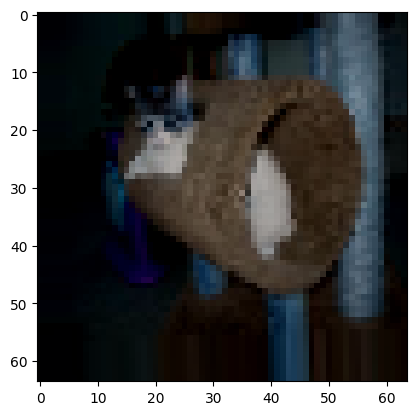

In [8]:
print(train_set.class_indices)
for image_batch, labels_batch in train_set:
	print(image_batch.shape)
	print(labels_batch.shape)

	img = image_batch[0] - image_batch[1].min()
	img = img / 275.0

	print(img.min(), img.max())
	plt.imshow(img)

	print('class:', labels_batch[0])
	break

In [13]:
ids, counts = np.unique(train_set.classes, return_counts=True)
print(ids)
print(counts)

[0 1]
[161 160]


### Create Model

- Load Pre-trained model & weight 
- delete top section 
- remain Feature Extraction section
- create top section involve with my project

In [30]:
in_shape = (target_img_shape[0], target_img_shape[1], 3)
in_shape

(64, 64, 3)

In [31]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=in_shape)

In [32]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [49]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,977,089
Trainable params: 262,401
Non-trainable params: 14,714,688
_________________________________________________________________


In [51]:
for layer in model.layers:
	print(f'{layer.name} {layer.trainable}')

vgg16 False
flatten_2 True
dense_4 True
dense_5 True


In [52]:
print('Trainable..\n---')
for variable in model.trainable_variables:
	print(variable.name)

Trainable..
---
dense_4/kernel:0
dense_4/bias:0
dense_5/kernel:0
dense_5/bias:0


In [37]:
base_model.trainable = False

In [53]:
print('Trainable..\n---')
for variable in model.trainable_variables:
	print(variable.name)

Trainable..
---
dense_4/kernel:0
dense_4/bias:0
dense_5/kernel:0
dense_5/bias:0


In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,977,089
Trainable params: 262,401
Non-trainable params: 14,714,688
_________________________________________________________________


### Compile Time

In [55]:
import time

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)


start = time.time()
history = model.fit(train_set, validation_data=val_set, epochs=20, verbose=1, callbacks=[es, mc])

end = time.time()
print('Time Taken: {:.2f} minutes'.format((end-start)/60))

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 8.0237 - accuracy: 0.5919
Epoch 1: val_accuracy improved from -inf to 0.69500, saving model to best_model.h5
11/11 [==============================] - 2s 131ms/step - loss: 8.0237 - accuracy: 0.5919 - val_loss: 4.4791 - val_accuracy: 0.6950
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.7793 - accuracy: 0.8287
Epoch 2: val_accuracy improved from 0.69500 to 0.72000, saving model to best_model.h5
11/11 [==============================] - 1s 101ms/step - loss: 1.7793 - accuracy: 0.8287 - val_loss: 4.7562 - val_accuracy: 0.7200
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.3619 - accuracy: 0.8474
Epoch 3: val_accuracy improved from 0.72000 to 0.75000, saving model to best_model.h5
11/11 [==============================] - 1s 101ms/step - loss: 1.3619 - accuracy: 0.8474 - val_loss: 3.6154 - val_accuracy: 0.7500
Epoch 4/20
11/11 [==============================] - ETA: 0s - loss: 1.

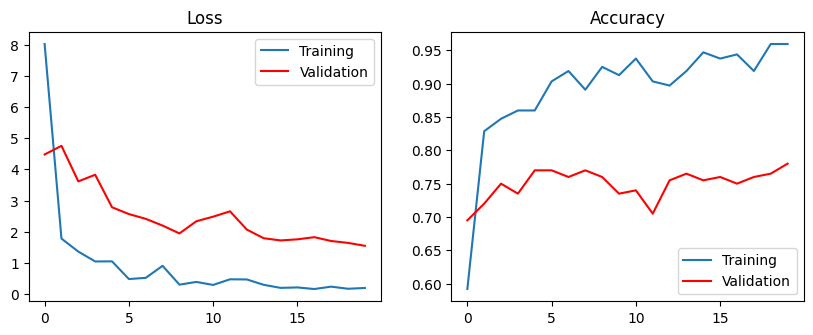

7/7 [==============================] - 0s 34ms/step - loss: 1.5474 - accuracy: 0.7800
score = 0.780


In [56]:
plt.figure(figsize=(10, 3.5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'],'r', label='Validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'],'r', label='Validation')
plt.legend()
plt.show()

acc = model.evaluate(val_set, steps=len(val_set), verbose=1)
print('score = {:.3f}'.format(acc[1]))

### Model Testing

In [70]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [74]:
train_set.class_indices

{'cat': 0, 'dog': 1}

In [73]:
img = load_img('./test_set/1.jpg', target_size=(64, 64))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
pred = model.predict(img)
print(pred[0][0])

1/1 [==============================] - 0s 22ms/step
0.99999976


In [78]:
def predict_dog_or_cat(lst):
	img_list = []; y_pred = []; y_pred_cls = []

	for i in lst:
		img = load_img(i, target_size=(64, 64))
		img_list.append(img)
		img = img_to_array(img)
		img = preprocess_input(img)

		img = np.expand_dims(img, axis=0)
		y_pred_i = model.predict(img)
		y_pred_cls_i = 'Dog' if y_pred_i[0][0] > 0.5 else 'Cat'
		y_pred.append(y_pred_i)
		y_pred_cls.append(y_pred_cls_i)

	return img_list, y_pred_cls, y_pred


In [79]:
import glob
mylist = [f for f in glob.glob('./test_set/*')]
img_list, y_pred_cls, y_prd = predict_dog_or_cat(mylist)

1/1 [==============================] - 0s 31ms/step


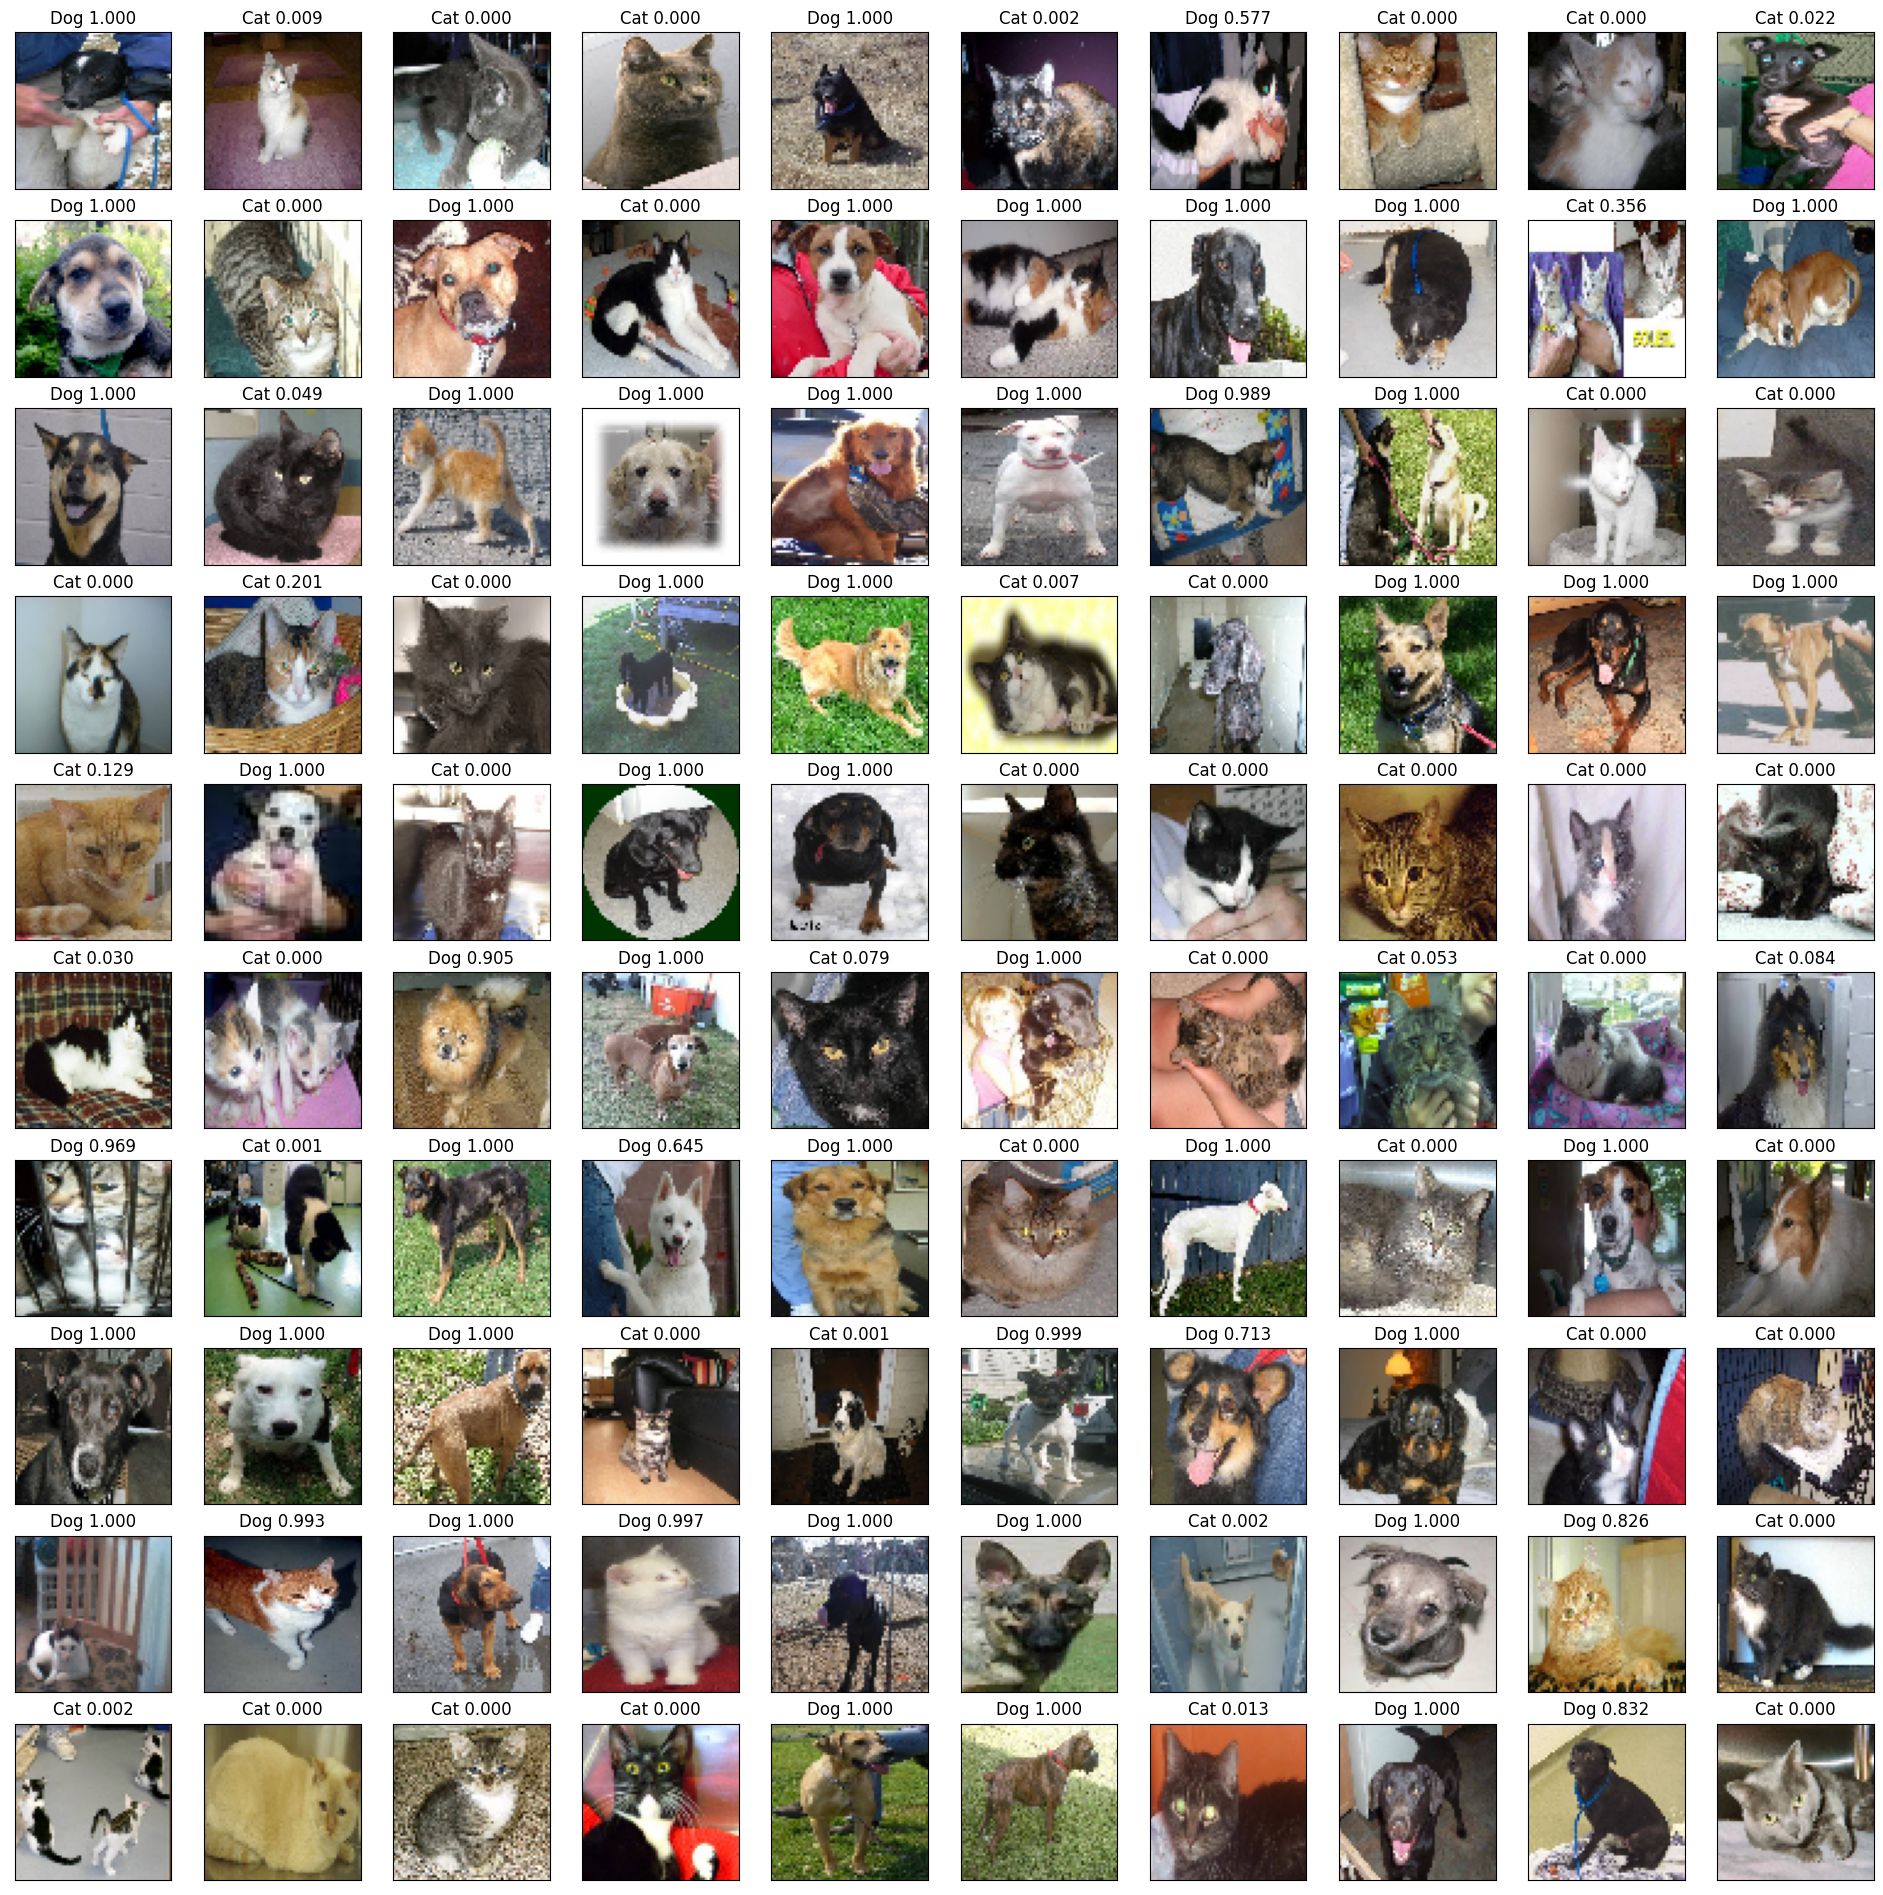

In [87]:
plt.figure(figsize=(24, 24))
for i,k in enumerate(img_list):
	plt.subplot(10, 10, i + 1)
	plt.imshow(k)
	plt.title('{} {:.3f}'.format(y_pred_cls[i], y_prd[i][0][0]))
	plt.xticks([])
	plt.yticks([])
plt.show()